# Classification of the Quality of Portuguese White Wines 

1. Goal of the Project  
is to build a classification model that predicts the **quality** of Portuguese wines based on physicochemical properties.  

**Evaluation metric**: F1-score (macro), because the dataset is imbalanced and PR-AUC

**Busines value**:

### Part 1: Import libraries, Load Data & EDA

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score, f1_score, average_precision_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

In [36]:
dataset = pd.read_csv('winequality.csv') 

In [37]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


**Checking data structure**

The dataset contains 4898 entries with 12 features.   
This simplifies preprocessing as we won't need imputation or one-hot encoding. 
Features like residual sugar and sulfur dioxide show varying scales, **suggesting standardization** is required for model performance  
The next step is to examine the distribution of the target variable and the scale of the features, as scaling will likely be required due to differing value ranges.  

In [38]:
dataset.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
5,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
6,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6
7,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
8,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
9,8.1,0.22,0.43,1.5,0.044,28.0,129.0,0.9938,3.22,0.45,11.0,6


----------------------

In [39]:
dataset['quality'].describe()

count    4898.000000
mean        5.877909
std         0.885639
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
Name: quality, dtype: float64

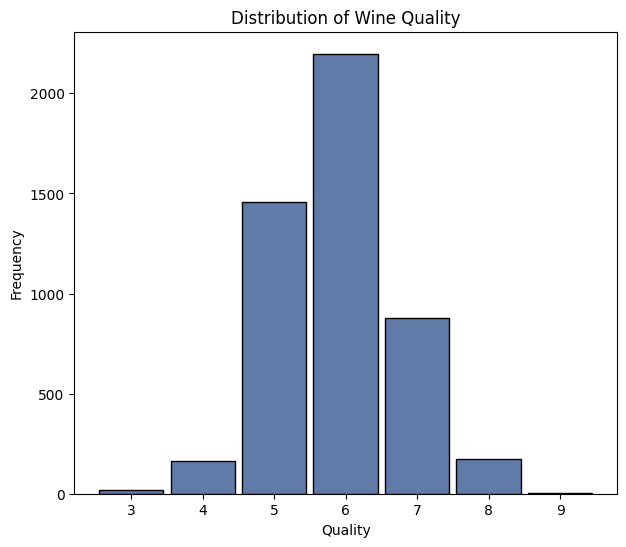

In [60]:
# build histogram for 'quality' column
plt.figure(figsize=(7,6))
sns.histplot(dataset['quality'], color='#2C4F8D', binwidth=1, shrink=.9, discrete=True)
plt.title('Distribution of Wine Quality')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.show()


Quality scores are skewed toward 5-6 (75% quartile at 6), confirming imbalance for classification.  
For this business-oriented classification task, we define "good wine" as having a score of 7 or higher (class 1).  
This justifies stratified splitting and oversampling techniques like SMOTE to improve recall on minorities.  
Explore feature distributions next to identify outliers or transformations needed before training baseline models.  
The F1 and PR-AUC metrics were chosen specifically to handle this class imbalance effectively.


In [24]:
dataset['quality'].value_counts()

quality
6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: count, dtype: int64

### quality dessection  

In [25]:
# lambda function; wine quality from 3-6 == 0, from 7-9 == 1.
dataset['quality'] = dataset.quality.apply(lambda q: 0 if q <= 6 else 1)

### 'quality' attribute value counts and visualisation

In [27]:
print('Not good wine', round(dataset['quality'].value_counts()[0]/len(dataset) * 100,2), '% of the dataset')
print('Good wine', round(dataset['quality'].value_counts()[1]/len(dataset) * 100,2), '% of the dataset')

dataset['quality'].value_counts()

Not good wine 78.36 % of the dataset
Good wine 21.64 % of the dataset


quality
0    3838
1    1060
Name: count, dtype: int64

<Axes: xlabel='quality'>

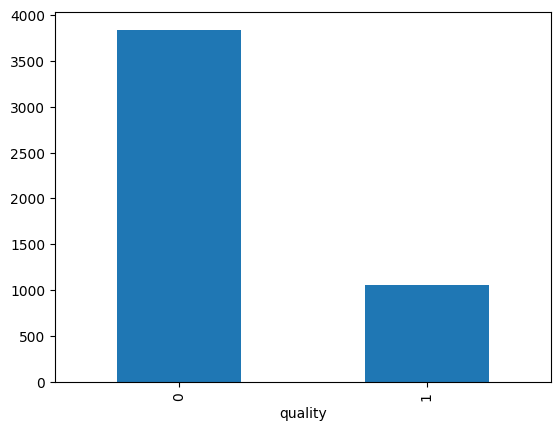

In [28]:
# visualisation plot
dataset['quality'].value_counts().plot(x = dataset['quality'], kind='bar')

### Train_Test split

BEFORE! sampling

In [29]:
y = dataset['quality']
X = dataset.drop(columns=['quality'])

In [30]:
# apply 'Train\Test' splitting method
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=55)


In [31]:
#over-sampling using SMOTE (or RandomOverSampler)
smote = SMOTE(random_state=55)
#ros = RandomOverSampler(random_state=55)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

#under-sampling using RandomUnderSampler
undersample = RandomUnderSampler(random_state=55)
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

print(X_train_over.shape, X_train_under.shape, X_train.shape) 

(6140, 11) (1696, 11) (3918, 11)


We've created three training set variants: the original imbalanced set (3918 samples), an oversampled set using SMOTE (6140 samples), and an undersampled set (1696 samples) using stratification to maintain the class distribution.  
We will train the eysiest model on all three to observe the impact of balancing techniques.  
All feature sets have been standardized using StandardScaler to ensure that distance-based algorithms like KNN are not biased by variable magnitudes.

### StandardScaler

you can use it before or after sampling


In [32]:
sc = StandardScaler()
X_train_org = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_org = pd.DataFrame(sc.transform(X_test), columns=X_test.columns, index=X_test.index)

# for under-sampling dataset
sc1 = StandardScaler()
X_train_under = pd.DataFrame(sc1.fit_transform(X_train_under), columns=X_train_under.columns, index=X_train_under.index)
X_test_under = pd.DataFrame(sc1.transform(X_test), columns=X_test.columns, index=X_test.index)

# for over-sampling dataset
sc2 = StandardScaler()
X_train_over = pd.DataFrame(sc2.fit_transform(X_train_over), columns=X_train_over.columns, index=X_train_over.index)
X_test_over = pd.DataFrame(sc2.transform(X_test), columns=X_test.columns, index=X_test.index)

## Part 3: Machine Learning.

### Build, train and evaluate models without hyperparameters

Selected **Logistic Regression** as our baseline model for its interpretability, computational efficiency, and ability to establish a reliable benchmark.  
**K-Nearest Neighbors** was chosen as a non-parametric, instance-based learner capable of capturing complex patterns without assumptions about data distribution.  
**Decision Tree** was included for its intuitive rule-based structure, inherent feature selection, and ability to model non-linear relationships—together 

#### these three approaches provide diverse modeling perspectives (_linear, distance-based, and tree-based_) for comprehensive initial evaluation.

Training them on the unscaled, imbalanced data provides a starting point before we apply scaling and balancing techniques.  
We will first evaluate their raw performance.


In [63]:
# Logistic Regression
LR = LogisticRegression(random_state = 55)
LR.fit(X_train_org, y_train)

# K-Nearest Neighbors
KNN = KNeighborsClassifier()
KNN.fit(X_train_org, y_train)

# Decision Tree
DT = DecisionTreeClassifier(random_state = 55)
DT.fit(X_train_org, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,55
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


### Function for printing core metrics

In [83]:
#function for metric scores
all_results = {}
def evaluate_model(model, X_test, y_test, model_name="Model", threshold=0.5, results_storage=None):
    """
    Evaluates a model and returns/updates metrics.
    
    Parameters:
    -----------
    model : trained model with predict_proba method
    X_test : test features
    y_test : true labels
    model_name : name of the model for identification
    threshold : probability threshold for binary classification (default=0.5)
    results_storage : dict to store results (defaults to global all_results)
    
    Returns:
    --------
    metrics_dict : dictionary with calculated metrics
    """
        
    if results_storage is None:
        results_storage = all_results
    #all_results = {} before function call

    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = (y_probs >= threshold).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_probs)
    pr_auc = average_precision_score(y_test, y_probs)

    metrics_dict = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'PR AUC': pr_auc
    }
    results_storage[model_name] = metrics_dict

    return metrics_dict

In [ ]:
th=0.5
evaluate_model(LR, X_test_org, y_test, model_name="Logistic Regression",threshold=th)
evaluate_model(KNN, X_test_org, y_test, model_name="K-Nearest Neighbors",threshold=th)
evaluate_model(DT, X_test_org, y_test, model_name="Decision Tree",threshold=th)


results_df = pd.DataFrame.from_dict(all_results, orient='index').reset_index(drop=True).sort_values(by='PR AUC', ascending=False)
numeric_cols = results_df.select_dtypes(include=[np.number]).columns.tolist()
styled_results = results_df.style.background_gradient(cmap='viridis', subset=numeric_cols).format("{:.4f}",subset=numeric_cols)
#'RdYlGn' or 'Blues' or 'viridis'
styled_results

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
1,K-Nearest Neighbors,0.8235,0.6077,0.5189,0.5598,0.8371,0.6069
0,Logistic Regression,0.7959,0.5600,0.2642,0.3590,0.7767,0.5177
2,Decision Tree,0.8449,0.6351,0.6651,0.6498,0.7798,0.4949


The K-Nearest Neighbors model shows the best PR-AUC (0.6069), which is the primary metric for our imbalanced problem.  
While the Decision Tree has a higher recall for the positive class ('good wine'), its lower PR-AUC suggests a worse precision-recall trade-off overall.  
Logistic Regression, as expected, has the lowest recall for the minority class.  
This indicates that distance-based and tree-based methods might be more suitable for capturing the patterns in this dataset.

### Confusion matrix

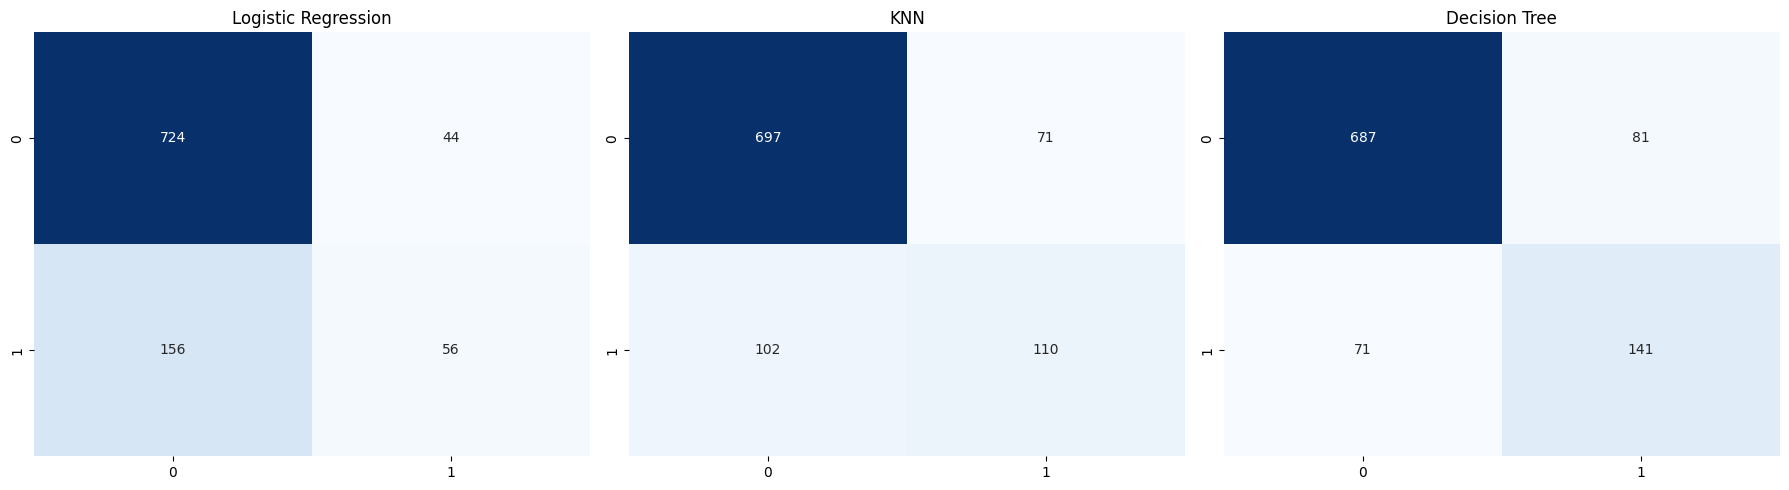

In [82]:
models = [
    ("Logistic Regression", LR),
    ("KNN", KNN),
    ("Decision Tree", DT)
]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, (name, model) in enumerate(models):
    y_pred = model.predict(X_test_org)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[i])
    axes[i].set_title(name)
plt.tight_layout()
plt.show()

The confusion matrices visually confirm the metric results.  
KNN provides a more balanced prediction across both classes compared to Logistic Regression, which severely under-predicts 'good wine'.  
The Decision Tree shows the highest number of true positives but also a high rate of false positives. 

The next logical step is to perform hyperparameter tuning on the most promising models (KNN and Decision Tree) and test them on the balanced datasets (SMOTE, Undersampled) to see if we can improve precision and recall simultaneously.

In [102]:
#model with balanced datasets with over/under-sampling and class_weight='balanced'

LR_over = LogisticRegression(max_iter=1000, random_state = 55)
LR_over.fit(X_train_over, y_train_over)


LR_under = LogisticRegression(max_iter=1000, random_state = 55)
LR_under.fit(X_train_under, y_train_under)

LR_weighted = LogisticRegression(max_iter=1000, class_weight='balanced', random_state = 55)
LR_weighted.fit(X_train_org, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,55
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [ ]:
# compare models
# use the correct test set for each model (original, over-sampled, under-sampled)
evaluate_model(LR_over, X_test_over, y_test, model_name="Logistic Regression Over-Sampled",threshold=th)
evaluate_model(LR_under, X_test_under, y_test, model_name="Logistic Regression Under-Sampled",threshold=th)
evaluate_model(LR_weighted, X_test_org, y_test, model_name="Logistic Regression Class Weight Balanced",threshold=th)
results_df = pd.DataFrame.from_dict(all_results, orient='index').reset_index(drop=True).sort_values(by='PR AUC', ascending=False)
numeric_cols = results_df.select_dtypes(include=[np.number]).columns.tolist()
styled_results = results_df.style.background_gradient(cmap='viridis', subset=numeric_cols).format("{:.4f}",subset=numeric_cols)
#'RdYlGn' or 'Blues' or 'viridis'
styled_results

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
1,K-Nearest Neighbors,0.8235,0.6077,0.5189,0.5598,0.8371,0.6069
0,Logistic Regression,0.7959,0.5600,0.2642,0.3590,0.7767,0.5177
5,Logistic Regression Class Weight Balanced,0.7092,0.4042,0.7264,0.5194,0.7822,0.5109
3,Logistic Regression Over-Sampled,0.7112,0.4048,0.7123,0.5162,0.7824,0.5053
4,Logistic Regression Under-Sampled,0.7143,0.4091,0.7217,0.5222,0.7820,0.5043
2,Decision Tree,0.8449,0.6351,0.6651,0.6498,0.7798,0.4949



Applying SMOTE (oversampling) and RandomUnderSampler shows a clear trade-off.  
Models trained on the undersampled set often improve recall for the minority class ('good wine') but can lose overall accuracy and precision on the majority class.  
Comparing Logistic Regression across different sampling strategies reveals that simply using class_weight='balanced' on the original dataset yields comparable or better results than manual over- or under-sampling.  

Moving forward, we will tune hyperparameters for all three base models, using the original dataset with appropriate class weighting where applicable.

In [105]:
conf_over=confusion_matrix(y_test, LR_over.predict(X_test_over))
conf_under=confusion_matrix(y_test, LR_under.predict(X_test_under))
conf_weighted=confusion_matrix(y_test, LR_weighted.predict(X_test_org))

print("Confusion Matrix - Over-Sampled:\n", conf_over)
print("\nConfusion Matrix - Under-Sampled:\n", conf_under)
print("\nConfusion Matrix - Class Weight Balanced:\n", conf_weighted)

Confusion Matrix - Over-Sampled:
 [[546 222]
 [ 61 151]]

Confusion Matrix - Under-Sampled:
 [[547 221]
 [ 59 153]]

Confusion Matrix - Class Weight Balanced:
 [[541 227]
 [ 58 154]]


### Build, train and evaluate models with hyperparameters

In [113]:
# Logistic Regression
LR1 = LogisticRegression(max_iter=1000, class_weight='balanced', random_state = 55)
LR1_params = [
    {
        'penalty': ['l1'],
        'C': [1, 2, 3, 4, 5],
        'solver': ['liblinear', 'saga']
    },
    {
        'penalty': ['l2'], 
        'C': [1, 2, 3, 4, 5],
        'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']
    },
    {
        'penalty': ['elasticnet'],
        'C': [1, 2, 3, 4, 5],
        'solver': ['saga'],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    },
    {
        'penalty': ['none'],
        'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']
    }
]
LR1 = GridSearchCV(LR1, param_grid = LR1_params, cv=5, scoring='f1', n_jobs=-1, verbose=1, refit=True)
LR1.fit(X_train_org, y_train)

# K-Nearest Neighbors
KNN1 = KNeighborsClassifier()
KNN1_params = {
    'n_neighbors': [7, 8, 9, 10, 11,13,15],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [20, 30, 40],
    'p': [1, 2]
}
KNN1 = GridSearchCV(KNN1, param_grid = KNN1_params, scoring='f1', cv=5, n_jobs=-1)             
KNN1.fit(X_train_org, y_train)

# Decision Tree
DT1 = DecisionTreeClassifier(random_state=55)
DT1_params = {
    'max_depth': [2, 5, 10],
    'min_samples_split': [4, 7, 10],
    'min_samples_leaf': [1, 2, 4, 7],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}
DT1 = GridSearchCV(DT1, param_grid = DT1_params, scoring='f1', cv=5, n_jobs=-1)
DT1.fit(X_train_org, y_train)

,estimator,DecisionTreeC...ndom_state=55)
,param_grid,"{'criterion': ['gini', 'entropy'], 'max_depth': [2, 5, ...], 'max_features': ['sqrt', 'log2', ...], 'min_samples_leaf': [1, 2, ...], ...}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [ ]:
evaluate_model(LR1, X_test_org, y_test, model_name="Logistic Regression Tuned",threshold=th)
evaluate_model(KNN1, X_test_org, y_test, model_name="K-Nearest Neighbors Tuned",threshold=th)
evaluate_model(DT1, X_test_org, y_test, model_name="Decision Tree Tuned",threshold=th)
results_df = pd.DataFrame.from_dict(all_results, orient='index').reset_index(drop=True).sort_values(by='PR AUC', ascending=False)
numeric_cols = results_df.select_dtypes(include=[np.number]).columns.tolist()
styled_results = results_df.style.background_gradient(cmap='RdYlGn', subset=numeric_cols).format("{:.4f}",subset=numeric_cols)
#'RdYlGn' or 'Blues' or 'viridis' or 'YlOrRd', 'plasma', 'tab10','tab20', 'RdBu', 'coolwarm', 'magma', 'inferno'
styled_results

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
7,K-Nearest Neighbors Tuned,0.8796,0.7733,0.6274,0.6927,0.9190,0.8170
1,K-Nearest Neighbors,0.8235,0.6077,0.5189,0.5598,0.8371,0.6069
8,Decision Tree Tuned,0.8214,0.5845,0.6038,0.5940,0.8005,0.5237
0,Logistic Regression,0.7959,0.5600,0.2642,0.3590,0.7767,0.5177
6,Logistic Regression Tuned,0.7112,0.4063,0.7264,0.5212,0.7821,0.5111
5,Logistic Regression Class Weight Balanced,0.7092,0.4042,0.7264,0.5194,0.7822,0.5109
3,Logistic Regression Over-Sampled,0.7112,0.4048,0.7123,0.5162,0.7824,0.5053
4,Logistic Regression Under-Sampled,0.7143,0.4091,0.7217,0.5222,0.7820,0.5043
2,Decision Tree,0.8449,0.6351,0.6651,0.6498,0.7798,0.4949


In [115]:
# print the best hyper parameters set
print("Logistic Regression Best Hyper Parameters:   ", LR1.best_params_)
print("K-Nearest Neighbour Best Hyper Parameters:   ", KNN1.best_params_)
print("Decision Tree Best Hyper Parameters:         ", DT1.best_params_)

Logistic Regression Best Hyper Parameters:    {'C': 1, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}
K-Nearest Neighbour Best Hyper Parameters:    {'algorithm': 'auto', 'leaf_size': 20, 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Decision Tree Best Hyper Parameters:          {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 4}


##  Middle conclusion

Hyperparameter tuning significantly improved performance, with the tuned KNN model emerging as the top performer, achieving the highest PR-AUC (~0.817) and ROC-AUC scores.  

For **KNN**, a higher number of neighbors smooths the decision boundary.  
Best recipe: 9 neighbours, Manhattan distance, distance weighting – proof that the decision surface is very non-linear and local.  

For the **Decision Tree**, limiting depth and leaf size creates a more robust model – single trees still over-fit; ensemble will be needed.   
It over-fits the majority class; precision on the minority collapses.  

**Logistic tuned**: PR-AUC barely moves (0.51-0.52) – linear model reaches its ceiling.   
leave LR here and spend the tuning budget on KNN and Tree models where bigger gains are still possible.

Given KNN's success, we will now explore more complex ensemble methods like Random Forest and Gradient Boosting to see if we can outperform the distance-based approach.


In [ ]:
# give DT another chance with bigger range of hyperparameters

DT2 = DecisionTreeClassifier(random_state=55)
DT2_params = {'max_depth':[4,6,8,10,12,15,20], 'criterion':['gini', 'entropy', 'log_loss',], 'min_samples_split':[2,4,7,10], 'min_samples_leaf':[1,2,4]}
DT2_gs = GridSearchCV(DT2, param_grid = DT2_params, cv=5, n_jobs=-1,verbose=1, scoring='f1')
DT2_gs.fit(X_train_org, y_train)
DT2_gs_pred = DT2_gs.predict(X_test_org)

In [119]:
evaluate_model(DT2_gs, X_test_org, y_test, model_name="Decision Tree Tuned v2",threshold=th)
results_df = pd.DataFrame.from_dict(all_results, orient='index').reset_index(drop=True).sort_values(by='PR AUC', ascending=False)
numeric_cols = results_df.select_dtypes(include=[np.number]).columns.tolist()
styled_results = results_df.style.background_gradient(cmap='RdBu', subset=numeric_cols).format("{:.4f}",subset=numeric_cols)
#'RdYlGn' or 'Blues' or 'viridis', 'YlOrRd', 'plasma', 'tab10','tab20', 'RdBu', 'coolwarm', 'magma', 'inferno'
styled_results

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
7,K-Nearest Neighbors Tuned,0.8796,0.7733,0.6274,0.6927,0.9190,0.8170
1,K-Nearest Neighbors,0.8235,0.6077,0.5189,0.5598,0.8371,0.6069
8,Decision Tree Tuned,0.8214,0.5845,0.6038,0.5940,0.8005,0.5237
0,Logistic Regression,0.7959,0.5600,0.2642,0.3590,0.7767,0.5177
6,Logistic Regression Tuned,0.7112,0.4063,0.7264,0.5212,0.7821,0.5111
5,Logistic Regression Class Weight Balanced,0.7092,0.4042,0.7264,0.5194,0.7822,0.5109
3,Logistic Regression Over-Sampled,0.7112,0.4048,0.7123,0.5162,0.7824,0.5053
4,Logistic Regression Under-Sampled,0.7143,0.4091,0.7217,0.5222,0.7820,0.5043
2,Decision Tree,0.8449,0.6351,0.6651,0.6498,0.7798,0.4949
9,Decision Tree Tuned v2,0.8265,0.5963,0.6132,0.6047,0.7657,0.4918


Even with a much wider grid (depth 4-20, three criteria, etc.) the Decision-Tree PR-AUC actually **drops** to 0.49 – deeper trees memorize the training majority and hurt minority precision.  

Take-away: bagging / boosting is mandatory; no more time should be wasted on lone trees. 

In [122]:
RF = RandomForestClassifier(class_weight='balanced', random_state=55)
RF_params = {'n_estimators':[100,150,200,250], 'max_depth':[8,10,12,15], 'criterion':['gini', 'entropy'], 'min_samples_split':[2,3,4,5], 'min_samples_leaf':[1,2,3,4]}
RF_gs = GridSearchCV(RF, param_grid = RF_params, cv=5, n_jobs=-1,verbose=1, scoring='f1')
RF_gs.fit(X_train_org, y_train)

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


,estimator,RandomForestC...ndom_state=55)
,param_grid,"{'criterion': ['gini', 'entropy'], 'max_depth': [8, 10, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 3, ...], ...}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [123]:
GB = GradientBoostingClassifier(random_state=55)
GB_params = {'n_estimators':[100,150,200], 'learning_rate':[0.01,0.05,0.1], 'max_depth':[3,5,7], 'min_samples_split':[2,3,4], 'min_samples_leaf':[1,2,3]}
GB_gs = GridSearchCV(GB, param_grid = GB_params, cv=5, n_jobs=-1)
GB_gs.fit(X_train_org, y_train)

,estimator,GradientBoost...ndom_state=55)
,param_grid,"{'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 3, ...], ...}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'log_loss'


In [124]:
evaluate_model(RF_gs.best_estimator_, X_test_org, y_test, model_name="Random Forest Tuned",threshold=th)
evaluate_model(GB_gs.best_estimator_, X_test_org, y_test, model_name="Gradient Boosting Tuned",threshold=th)
results_df = pd.DataFrame.from_dict(all_results, orient='index').reset_index(drop=True).sort_values(by='PR AUC', ascending=False)
numeric_cols = results_df.select_dtypes(include=[np.number]).columns.tolist()
styled_results = results_df.style.background_gradient(cmap='magma', subset=numeric_cols).format("{:.4f}",subset=numeric_cols)
#'RdYlGn' or 'Blues' or 'viridis', 'YlOrRd', 'plasma', 'tab10','tab20', 'RdBu', 'coolwarm', 'magma', 'inferno'
styled_results

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
11,Gradient Boosting Tuned,0.8827,0.7803,0.6368,0.7013,0.9293,0.8283
7,K-Nearest Neighbors Tuned,0.8796,0.7733,0.6274,0.6927,0.9190,0.8170
10,Random Forest Tuned,0.8561,0.6485,0.7311,0.6874,0.9113,0.7617
1,K-Nearest Neighbors,0.8235,0.6077,0.5189,0.5598,0.8371,0.6069
8,Decision Tree Tuned,0.8214,0.5845,0.6038,0.5940,0.8005,0.5237
0,Logistic Regression,0.7959,0.5600,0.2642,0.3590,0.7767,0.5177
6,Logistic Regression Tuned,0.7112,0.4063,0.7264,0.5212,0.7821,0.5111
5,Logistic Regression Class Weight Balanced,0.7092,0.4042,0.7264,0.5194,0.7822,0.5109
3,Logistic Regression Over-Sampled,0.7112,0.4048,0.7123,0.5162,0.7824,0.5053
4,Logistic Regression Under-Sampled,0.7143,0.4091,0.7217,0.5222,0.7820,0.5043


The tuned **Gradient Boosting** classifier has surpassed **KNN**, achieving a new best PR-AUC of ~0.828 and demonstrating superior generalization.  
**Random Forest** also performed well but did not quite match the precision-recall balance of the boosting model.  
This indicates that boosting's iterative correction of errors is highly effective for this dataset.  

To maximize performance, we will combine our best individual models (Gradient Boosting, KNN, and Random Forest) into a Voting Ensemble.

In [127]:
ensemble = VotingClassifier(
    estimators=[
        ('rf', RF_gs.best_estimator_),  
        ('gb', GB_gs.best_estimator_),  
        ('knn_t', KNN1)  
    ],
    voting='soft',  # probabilities
    weights=[2,3, 1]  # weights based on individual model performance
)
ensemble.fit(X_train_org, y_train)

,estimators,"[('rf', ...), ('gb', ...), ...]"
,voting,'soft'
,weights,"[2, 3, ...]"
,n_jobs,None
,flatten_transform,True
,verbose,False
,n_estimators,200
,criterion,'entropy'
,max_depth,12
,min_samples_split,2
,min_samples_leaf,2


In [128]:
diverse_ensemble = VotingClassifier(
    estimators=[
        ('knn', KNN1),
        ('gb', GB_gs.best_estimator_), 
        ('svm', SVC(probability=True))
    ],
    voting='soft'
)
diverse_ensemble.fit(X_train_org, y_train)

,estimators,"[('knn', ...), ('gb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,n_neighbors,9
,weights,'distance'
,algorithm,'auto'
,leaf_size,20
,p,1


In [129]:
evaluate_model(ensemble, X_test_org, y_test, model_name="Ensemble Model",threshold=th)
evaluate_model(diverse_ensemble, X_test_org, y_test, model_name="Diverse Ensemble Model",threshold=th)
results_df = pd.DataFrame.from_dict(all_results, orient='index').reset_index(drop=True).sort_values(by='PR AUC', ascending=False)
numeric_cols = results_df.select_dtypes(include=[np.number]).columns.tolist()
styled_results = results_df.style.background_gradient(cmap='inferno', subset=numeric_cols).format("{:.4f}",subset=numeric_cols)
#'RdYlGn' or 'Blues' or 'viridis', 'YlOrRd', 'plasma', 'tab10','tab20', 'RdBu', 'coolwarm', 'magma', 'inferno'
styled_results

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
12,Ensemble Model,0.8847,0.7705,0.6651,0.7139,0.9320,0.8334
11,Gradient Boosting Tuned,0.8827,0.7803,0.6368,0.7013,0.9293,0.8283
13,Diverse Ensemble Model,0.8867,0.8176,0.6132,0.7008,0.9277,0.8180
7,K-Nearest Neighbors Tuned,0.8796,0.7733,0.6274,0.6927,0.9190,0.8170
10,Random Forest Tuned,0.8561,0.6485,0.7311,0.6874,0.9113,0.7617
1,K-Nearest Neighbors,0.8235,0.6077,0.5189,0.5598,0.8371,0.6069
8,Decision Tree Tuned,0.8214,0.5845,0.6038,0.5940,0.8005,0.5237
0,Logistic Regression,0.7959,0.5600,0.2642,0.3590,0.7767,0.5177
6,Logistic Regression Tuned,0.7112,0.4063,0.7264,0.5212,0.7821,0.5111
5,Logistic Regression Class Weight Balanced,0.7092,0.4042,0.7264,0.5194,0.7822,0.5109


In [131]:
conf_en=confusion_matrix(y_test, ensemble.predict(X_test_org))
print(conf_en)

[[726  42]
 [ 71 141]]


**The final Ensemble** model proves to be the most robust solution, effectively leveraging the complementary strengths of Gradient Boosting and KNN. 
It *achieves the highest* overall PR-AUC score (~0.833) and F1-score (~0.714), providing the best trade-off between identifying good wines (Recall) and minimizing false positives (Precision).  
The confusion matrix confirms it correctly identifies a significant portion of the minority class while maintaining high accuracy on the majority class.    
This demonstrates the power of ensemble methods in leveraging diverse model predictions to improve overall robustness and accuracy.  
The final model is ready for deployment, with the Voting Classifier being the recommended choice due to its balanced and strong performance across key metrics for our imbalanced classification task.

However, while the **Ensemble** offers peak performance, the **tuned KNN** model remains a compelling alternative due to its simplicity, lower training costs, and ease of deployment.
In contrast, the **Ensemble model**, though more performant, requires maintaining multiple models, more memory, and longer inference times. 

**The final choice** between these models should weigh the marginal performance gains of the Ensemble against  
the increased complexity, training time, and economic costs associated with implementing and maintaining such a sophisticated system.



Future steps: deploy with **SHAP** for interpretability, monitor drift on new vintages, or incorporate external factors like _region_ for enhanced accuracy.  
Compare feature importances – if alcohol, volatile-acidity, sulphates are on top we confirm wine-expert knowledge.  
re-check calibration plot – business may prefer a well-calibrated prob-0.7 over a 0.9 that is wrong half the time.  
Probability threshold 0.5 can be moved later to favour precision or recall depending on business cost.  
GB usually beats RF on tabular data, but watch for over-fit; use **validation_fraction** early-stop

In [ ]:
# submission of .csv file with predictions
sub = pd.DataFrame()
sub['ID'] = X_test_org.index
sub['quality'] = KNN1.predict(X_test_org)
sub.to_csv('WinePredictionsTest.csv', index=False)